# Inference: Log priors

This example notebook illustrates some of the functionality that is available for `LogPrior` objects that are currently available within PINTS.

In [1]:
import pints
import numpy as np
import matplotlib.pyplot as plt

The uniform prior, $U\sim(a, b)$, here with $a=-10$ and $b=15$. When this function is called, its log density is returned.

In [2]:
uniform_log_prior = pints.UniformLogPrior(-10, 15)

print('U(0|a=-10, b=15) = ' + str(uniform_log_prior([0])))

U(0|a=-10, b=15) = -3.2188758248682006


To plot the density, we take the exponential of its log density.

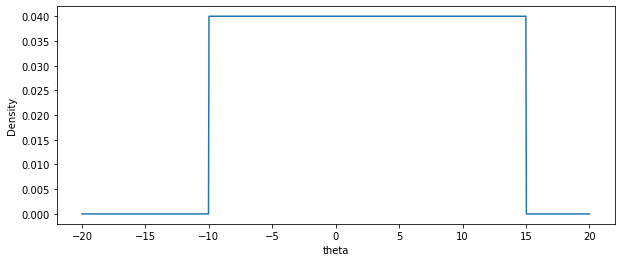

In [3]:
values = np.linspace(-20, 20, 1000)
log_prob = [uniform_log_prior([x]) for x in values]
prob = np.exp(log_prob)

plt.figure(figsize=(10,4))
plt.xlabel('theta')
plt.ylabel('Density')
plt.plot(values, prob)
plt.show()

To specify a multidimensional uniform prior, use the same function. Here we specify, $\theta_1\sim U(2, 4)$ and $\theta_2\sim U(-7,-5)$.

In [4]:
uniform_log_prior = pints.UniformLogPrior([2, -7], [4, -5])

Plot $p(\theta_2|\theta_1 = 3)$.

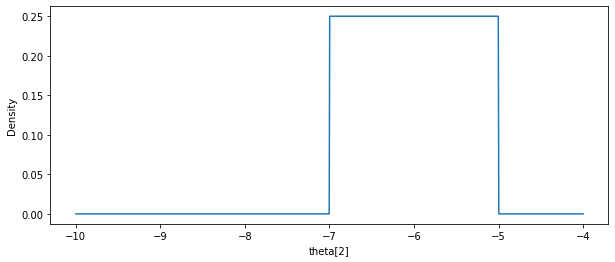

In [5]:
values = np.linspace(-10, -4, 1000)
log_prob = [uniform_log_prior([3, x]) for x in values]
prob = np.exp(log_prob)

plt.figure(figsize=(10,4))
plt.xlabel('theta[2]')
plt.ylabel('Density')
plt.plot(values, prob)
plt.show()

If you have a prior constrained to lie $\in[0,1]$, you can use a beta prior.

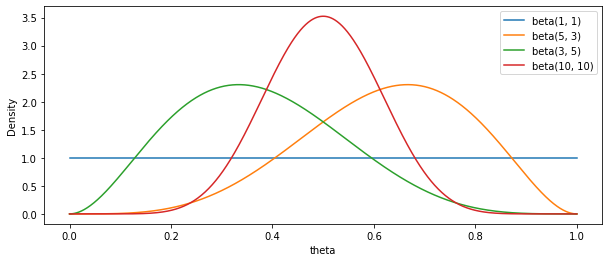

In [6]:
beta_log_prior1 = pints.BetaLogPrior(1, 1)
beta_log_prior2 = pints.BetaLogPrior(5, 3)
beta_log_prior3 = pints.BetaLogPrior(3, 5)
beta_log_prior4 = pints.BetaLogPrior(10, 10)

values = np.linspace(0, 1, 1000)
prob1 = np.exp([beta_log_prior1([x]) for x in values])
prob2 = np.exp([beta_log_prior2([x]) for x in values])
prob3 = np.exp([beta_log_prior3([x]) for x in values])
prob4 = np.exp([beta_log_prior4([x]) for x in values])

plt.figure(figsize=(10,4))
plt.xlabel('theta')
plt.ylabel('Density')
plt.plot(values, prob1)
plt.plot(values, prob2)
plt.plot(values, prob3)
plt.plot(values, prob4)
plt.legend(['beta(1, 1)', 'beta(5, 3)', 'beta(3, 5)', 'beta(10, 10)'])
plt.show()

Specifying a value outside the support of the distribution returns $-\infty$ for the log density.

In [7]:
print('beta(-0.5|a=1, b=1) = ' + str(beta_log_prior1([-0.5])))

beta(-0.5|a=1, b=1) = -inf


Each prior has a `mean` function that allows you to quickly check what parameterisation is being used.

In [8]:
print('mean = ' + str(beta_log_prior3.mean()))

mean = 0.375


Alternatively, if you need a prior constrained to lie $\in[a,b]$, but for which a Gaussian distribution might otherwise be appropriate, you can use the truncated normal prior.

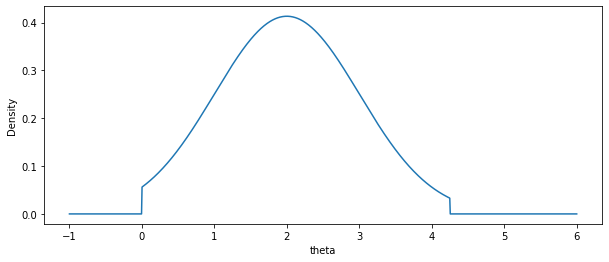

In [9]:
truncnorm_log_prior = pints.TruncatedNormalLogPrior(2.0, 1.0, 0.0, 4.25)

values = np.linspace(-1, 6, 1000)
prob = np.exp([truncnorm_log_prior([x]) for x in values])

plt.figure(figsize=(10,4))
plt.xlabel('theta')
plt.ylabel('Density')
plt.plot(values, prob)
plt.show()

Each prior also has a `sample` function which allows generation of independent samples from each distribution. Using this we can sample from a Student-t density, with input dimensions `(location, degrees of freedom, scale)`.

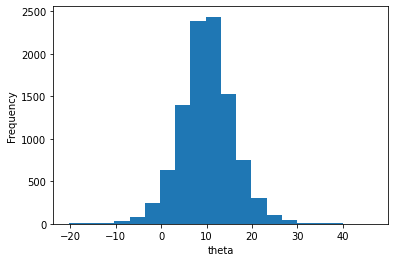

In [10]:
n = 10000
student_t_log_prior = pints.StudentTLogPrior(10, 8, 5)
samples = student_t_log_prior.sample(n)

plt.hist(samples, 20)
plt.xlabel('theta')
plt.ylabel('Frequency')
plt.show()

For models with multiple parameters, we can specify different distributions for each dimension using `ComposedLogPrior`.

In [11]:
log_prior1 = pints.GaussianLogPrior(6, 3)
log_prior2 = pints.InverseGammaLogPrior(5, 5)
log_prior3 = pints.LogNormalLogPrior(-1, 1)
composed_log_prior = pints.ComposedLogPrior(log_prior1, log_prior2, log_prior3)

# calling
composed_log_prior([-3, 1, 6])

-13.25607355949521

Functions like `sample` and `mean` also work for `ComposedLogPrior` objects.

mean = [6.0, 1.25, 0.6065306597126334]


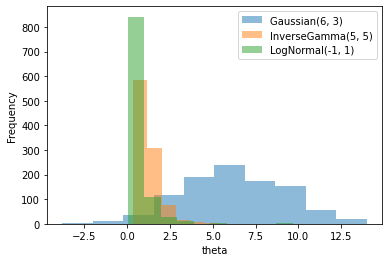

In [12]:
print('mean = ' + str(composed_log_prior.mean()))

n = 10
samples = composed_log_prior.sample(1000)
plt.hist(samples[:, 0], alpha=0.5)
plt.hist(samples[:, 1], alpha=0.5)
plt.hist(samples[:, 2], alpha=0.5)
plt.legend(['Gaussian(6, 3)', 'InverseGamma(5, 5)', 'LogNormal(-1, 1)'])
plt.xlabel('theta')
plt.ylabel('Frequency')
plt.show()

We also have multivariate priors in PINTS. For example, the multivariate Gaussian.

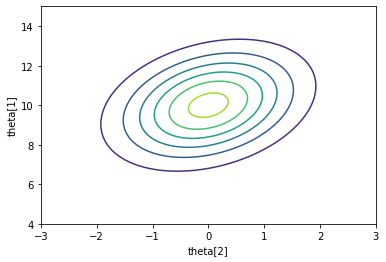

In [13]:
two_d_gaussian_log_prior = pints.MultivariateGaussianLogPrior([0, 10], [[1, 0.5], [0.5, 3]])

# Contour plot of pdf
x = np.linspace(-3, 3, 100)
y = np.linspace(4, 15, 100)
X, Y = np.meshgrid(x, y)
Z = np.exp([[two_d_gaussian_log_prior([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.xlabel('theta[2]')
plt.ylabel('theta[1]')
plt.show()

## Converting prior samples to be uniform within unit cube

Some inference methods only work when samples are uniformly distributed in unit cube. PINTS contains methods to convert prior samples to those from the unit cube (often but not only using the cumulative density function (CDF)).

Here we show how this function works for the multivariate Gaussian (a case of when a different transformation to the CDF is applied).

First, we show samples from the prior.

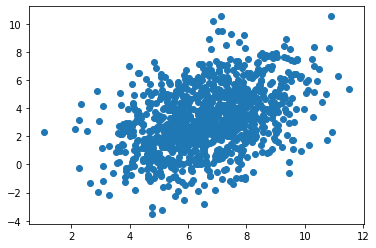

In [14]:
mean = [-5.5, 6.7, 3.2]
covariance = [[3.4, -0.5, -0.7], [-0.5, 2.7, 1.4], [-0.7, 1.4, 5]]
log_prior = pints.MultivariateGaussianLogPrior(mean, covariance)
n = 1000
samples = log_prior.sample(n)
plt.scatter(samples[:, 1], samples[:, 2])
plt.show()

Next, we show those samples after they have been converted to be uniform on the unit cube.

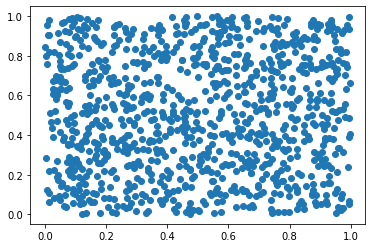

In [15]:
u = []
for i in range(n):
    u.append(log_prior.convert_to_unit_cube(samples[i]))
u = np.vstack(u)
plt.scatter(u[:, 1], u[:, 2])
plt.show()

And we can convert them back again.

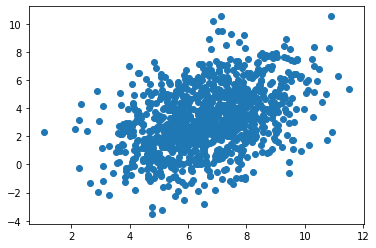

In [16]:
theta = []
for i in range(n):
    theta.append(log_prior.convert_from_unit_cube(u[i]))
theta = np.vstack(theta)
plt.scatter(theta[:, 1], theta[:, 2])
plt.show()